In [2]:
import sympy as sp
import numpy as np
from sympy.abc import s, z
from control import matlab as m
from utils.units import u, basis
from IPython.display import display

In [3]:
from utils.units.sympy_helpers import without_units

def usubs(var, val, expr):
    return without_units(expr,
        lambda dummify, expr: expr.subs(
            var, dummify(val)))

def var_in(var, unit, expr):
    return usubs(var, var/unit, expr)

In [4]:
gp = 1/(
    .25*s**2+.5*s+1
)

gp = var_in(s, u.rad/u.s, gp)
gp

1/(1 + 0.5*second*s/radian + 0.25*second**2*s**2/radian**2)

In [5]:
ts = 5.5*u.s
mp = 5*u.percent

In [6]:
nu = basis()
nu

NumericalBasis(mapper=QuantityMapper(salt=1910620209143589146), proxy_system=<UnitSystem: (meter, kilogram, second, ampere, mole, candela, kelvin)>)

In [7]:
from utils.ctrlsys import pole_specs
_, dp_s = pole_specs(nu[ts], nu[mp])
nu.to_symb(u.rad/u.s, dp_s).n(4)

radian*(-0.7113 + 0.7459*I)/second

In [8]:
wd = abs(dp_s)
td = 2*np.pi/wd
dt = nu.to_symb(u.s, td/20)
dt.n(4)

0.3048*second

In [26]:
wd/nu[u.Hz]

1.0306766744628757

In [9]:
from utils.ctrlsys import z_map
dp = z_map(dp_s, nu[dt])
sp.sympify(dp).n(4)

0.7844 + 0.1815*I

In [10]:
from utils.ctrl import expr2sys

gp_tf = expr2sys(nu.to_numeric(gp**-1, as_expr=True), s)**-1
gp_tf

TransferFunction(array([1.]), array([92.92486532,  9.63975442,  1.        ]))

In [11]:
gp_dtf = m.c2d(gp_tf, nu[dt])
gp_dtf

TransferFunction(array([0.14868848, 0.12110673]), array([ 1.        , -1.27376354,  0.54355874]), 5.876562927117034)

In [12]:
from utils.ctrl import sys2expr
gp_d = sys2expr(gp_dtf, z)
gp_d.n(4)

(0.1487*z + 0.1211)/(1.0*z**2 - 1.274*z + 0.5436)

In [13]:
k1, k2 = sp.symbols("K_1 K_2", real=True)

# controlador pd predictivo
gc_d = (k1*z+k2)/(z**2)

In [14]:
from utils.math import sp_reim as reim

def rlocus_cond(dp, z, fb):
    return fb.subs(z, dp)+1

# Separamos en parte real e imaginaria e igualamos a cero
# en lugar de usar fase y magnitud, ya que la multiplicidad
# de la fase causa problemas a la hora de comprar ángulos
# fuera del rango (-pi, pi]
k1_, k2_ = map(float, sp.nsolve(
    reim(rlocus_cond(dp, z, gp_d*gc_d)),
    (k1, k2), (.5, .5)
))
k1_, k2_

(-1.3870035628943547, 0.8129675611006658)

In [15]:
from utils.ctrlsys import autotune, feedforward

k1_, k2_ = autotune({k1: k1_, k2: k2_},
    z, m.tf("z"),
    gc_d,
    nu[mp]*.95, nu[ts]*.95,
    gp_dtf,
    1, config=feedforward, iter=30)
k1_, k2_

(-1.1446209295779952, 0.654816853240124)

In [16]:
from utils.ctrl import expr2sys
gc_dtf = expr2sys(gc_d.subs({k1: k1_, k2: k2_}), z)
gc_dtf

TransferFunction(array([-1.14462093,  0.65481685]), array([1., 0., 0.]), True)

In [17]:
from utils.ctrlsys import feedforward
gclff_dtf = feedforward(gp_dtf, gc_dtf)
gcl_dtf = m.feedback(gp_dtf*gc_dtf)

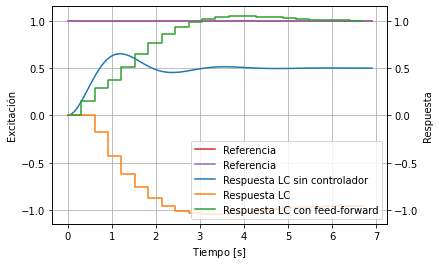

In [18]:
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrl import step_resp

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()
plot_step, plot_ref = step_resp(ax_e.plot, ax_r.plot, next_color)

nu_twinx_axes(
    nu, ax_e, ax_r,
    ("Tiempo", u.s),
    ("Excitación", 1),
    ("Respuesta", 1)
)

plot_step(m.feedback(gp_tf), label="Respuesta LC sin controlador")
plot_step(gcl_dtf, label="Respuesta LC")
plot_step(gclff_dtf, label="Respuesta LC con feed-forward")
plot_ref(label="Referencia")

plot_ref(label="Referencia")

ax_e.grid()
set_gain_and_legend_loc(1, "lower right")

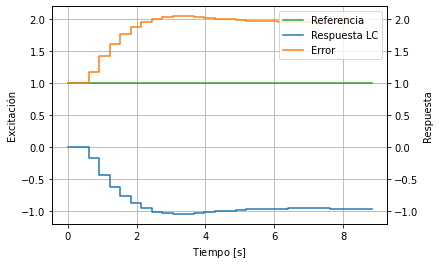

In [28]:
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrl import step_resp

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()
plot_step, plot_ref = step_resp(ax_e.plot, ax_r.plot, next_color)

nu_twinx_axes(
    nu, ax_e, ax_r,
    ("Tiempo", u.s),
    ("Excitación", 1),
    ("Respuesta", 1)
)

plot_step(gcl_dtf, label="Respuesta LC")
#plot_step(m.feedback(gc_dtf, gp_dtf), label="Acción de control")
plot_step(m.feedback(1, gc_dtf * gp_dtf), label="Error")
plot_ref(label="Referencia")

ax_e.grid()
set_gain_and_legend_loc(1, "upper right")

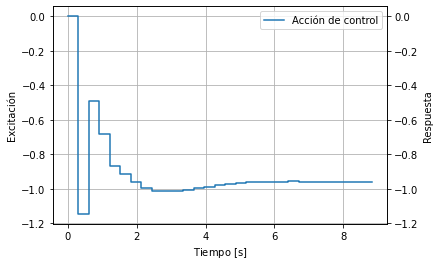

In [30]:
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrl import step_resp

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()
plot_step, plot_ref = step_resp(ax_e.plot, ax_r.plot, next_color)

nu_twinx_axes(
    nu, ax_e, ax_r,
    ("Tiempo", u.s),
    ("Excitación", 1),
    ("Respuesta", 1)
)

plot_step(m.feedback(gc_dtf, gp_dtf), label="Acción de control")

ax_e.grid()
set_gain_and_legend_loc(1, "upper right")

In [31]:
from utils.ctrlsys import difference_eq
from utils.ctrl import siso_numden

def my_diff_eq(sys, ff=False):
    e, u = map(sp.Function, "e u".split(" "))
    k = sp.symbols("k", real=True)
    res = difference_eq(*siso_numden(sys), e, u, k)
    if not ff:
        return res
    r = sp.Function("r")
    lhs, rhs = res.args
    return sp.Eq(lhs, rhs + r(k))

In [35]:
my_diff_eq(gc_dtf, ff=True).n(4)

Eq(u(k), 0.6548*e(k - 2) - 1.145*e(k - 1) + r(k))

In [34]:
gclff_dtf

TransferFunction(array([ 0.14868848, -0.42787314,  0.48667332, -0.15448685, -0.20191626,
        0.25750605, -0.12200271,  0.02343047,  0.        ,  0.        ]), array([ 1.        , -3.82129062,  6.32790495, -5.8285285 ,  3.25535433,
       -1.20717065,  0.38232208, -0.12200271,  0.02343047,  0.        ,
        0.        ]), 5.876562927117034)

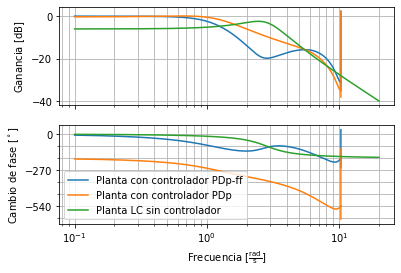

In [39]:
from utils.mpl import nu_sharex_axes
from utils.ctrl import bode_axes
from functools import partial

fig, (ax_gain, ax_phase), add_bode_, add_deg_locator = bode_axes()

add_bode = partial(add_bode_, deg=False, dB=True)

w = np.geomspace(10**-1, 20, num=1000)*nu[u.rad/u.s]
w_dtf = w[np.where(w<(1/nu[dt])*np.pi)]

add_bode(gclff_dtf, label="Planta con controlador PDp-ff", omega=w_dtf)
add_bode(gcl_dtf, label="Planta con controlador PDp", omega=w_dtf)
add_bode(m.feedback(gp_tf), label="Planta LC sin controlador", omega=w)

add_deg_locator(270)

nu_sharex_axes(nu, ax_phase, ax_gain,
    ("Frecuencia", u.rad/u.s),
    ("Cambio de fase", u.deg),
    ("Ganancia", 1),
    y2_in_db=True)

ax_gain.grid(which='both')
ax_phase.grid(which='both')

ax_phase.legend(); None

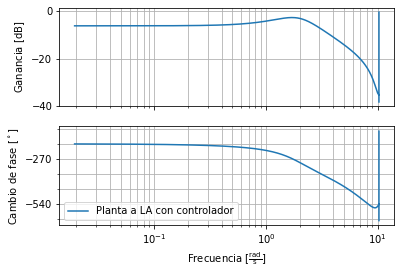

In [41]:
from utils.mpl import nu_sharex_axes
from utils.ctrl import bode_axes
from functools import partial

fig, (ax_gain, ax_phase), add_bode_, add_deg_locator = bode_axes()

add_bode = partial(add_bode_, deg=False, dB=True)

add_bode(gc_dtf*gp_dtf, label="Planta a LA con controlador")

add_deg_locator(270)

nu_sharex_axes(nu, ax_phase, ax_gain,
    ("Frecuencia", u.rad/u.s),
    ("Cambio de fase", u.deg),
    ("Ganancia", 1),
    y2_in_db=True)

ax_gain.grid(which='both')
ax_phase.grid(which='both')

ax_phase.legend(); None